# Top tagging model with ResNet-50 

This is a training script about using top tagging data to train a ResNet-50 Neuron Network. <br>
The training is base on Keras and using tensorflow backend to run.

## Import necessary package and do gpu test.

In [4]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import hdf5plugin 
import h5py 
import os
from keras.utils import np_utils
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPU


## Input data with H5py package
Input data size: 1 channel image with shape 224x224. <br>
Input label size: 1 or 0 with onehot encoding. <br>
\# of input data(train(with val), test): 30000,6000

In [5]:
img = []
label = []
prefix = "/home/david/ResNet-50-Keras/data/"
train_file = "train/train_file_"
#test_file = "test/test_file_"
#val_file = "val/val_file_"
file_type = ".h5"
path = []
filename = ''
def get_data():
    for i in range(1,4):
        seq =  (train_file, str(i),file_type)
        path = os.path.join(prefix, filename.join(seq))
        with h5py.File(path,'r') as f:
            pt_ = f['img_pt']
            label_ = f['label']
            for a in range(len(pt_)):
                img.append(pt_[a])
            for b in range(len(label_)):
                label.append(label_[b])  
    return np.asanyarray(img), np.asanyarray(label)
    
img, label_ = get_data()
"""
for i in range(0,1):
    seq =  (test_file, str(i),file_type)
    path = os.path.join(prefix, filename.join(seq))
    with h5py.File(path,'r') as f :
        pt_ = f['img_pt']
        label_ = f['label']
        for a in range(0,2000):
            test_img_pt.append(pt_[a])
        for b in range(0,2000):
            test_label_.append(label_[b])

            
for i in range(0,1):
    seq =  (val_file, str(i),file_type)
    path = os.path.join(prefix, filename.join(seq))
    with h5py.File(path,'r') as f :
        pt_ = f['img_pt']
        label_ = f['label']
        for a in range(0,2000):
            val_img_pt.append(pt_[a])
        for b in range(0,2000):
            val_label_.append(label_[b])
"""

"\nfor i in range(0,1):\n    seq =  (test_file, str(i),file_type)\n    path = os.path.join(prefix, filename.join(seq))\n    with h5py.File(path,'r') as f :\n        pt_ = f['img_pt']\n        label_ = f['label']\n        for a in range(0,2000):\n            test_img_pt.append(pt_[a])\n        for b in range(0,2000):\n            test_label_.append(label_[b])\n\n            \nfor i in range(0,1):\n    seq =  (val_file, str(i),file_type)\n    path = os.path.join(prefix, filename.join(seq))\n    with h5py.File(path,'r') as f :\n        pt_ = f['img_pt']\n        label_ = f['label']\n        for a in range(0,2000):\n            val_img_pt.append(pt_[a])\n        for b in range(0,2000):\n            val_label_.append(label_[b])\n"

In [6]:
print((255*img/img.max()).max(), (255*img/img.max()).min())

255.0 0.0


c1: 15000, c2: 15000


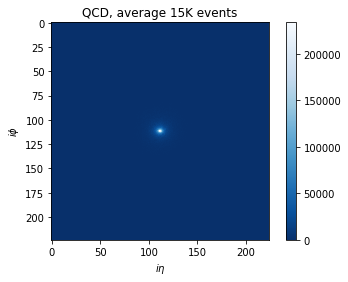

In [7]:
qq, c1, c2, tt = 0, 0, 0, 0 
for i in range(len(img)): 
    if (np.argmax(label[i]) == 1):
        qq += 255*img[i]/img[i].max()
        c1 += 1
    else :
        tt += 255*img[i]/img[i].max()
        c2 +=1
print("c1: {0}, c2: {1}".format(c1,c2))
plt.figure()        
color_map = plt.imshow(qq)
color_map.set_cmap("Blues_r")
plt.colorbar()
plt.xlabel(r'$i\eta$')
plt.ylabel(r'$i\phi$')
plt.title('QCD, average 15K events')
plt.savefig("qcd.png")

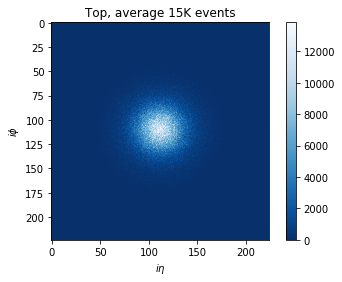

In [8]:
plt.figure()
color_map = plt.imshow(tt)
color_map.set_cmap("Blues_r")
plt.colorbar()
plt.xlabel(r'$i\eta$')
plt.ylabel(r'$i\phi$')
plt.title('Top, average 15K events')
plt.savefig("top.png")
qq, c1, c2, tt = 0, 0, 0, 0 

## Define function to do normalize and duplicate image to 3 channel. <br>
Image will be normalize to 0~255 and duplicate into 3 channel.

In [9]:
def normalize_and_rgb(images, label):  
    #normalize image to 0-255 per image.
    image_sum = 1/np.sum(np.sum(images,axis=1),axis=-1)
    given_axis = 0
    # Create an array which would be used to reshape 1D array, b to have 
    # singleton dimensions except for the given axis where we would put -1 
    # signifying to use the entire length of elements along that axis  
    dim_array = np.ones((1,images.ndim),int).ravel()
    dim_array[given_axis] = -1
    # Reshape b with dim_array and perform elementwise multiplication with 
    # broadcasting along the singleton dimensions for the final output
    image_sum_reshaped = image_sum.reshape(dim_array)
    images = images*image_sum_reshaped*255

    # make it rgb by duplicating 3 channels.
    images = np.stack([images, images, images],axis=-1)
    
    return images, label

image, label = normalize_and_rgb(img, label)


In [10]:
image.shape

(30000, 224, 224, 3)

In [11]:
train_img, train_label = [], []
test_img, test_label = [], []
val_img, val_label = [], []
def arrange_data():
    for i in range(0, 20000):
        train_img.append(image[i])
        train_label.append(label[i])
    for i in range(20000,22000):
        val_img.append(image[i])
        val_label.append(label[i])
    for i in range(22000,24000):
        test_img.append(image[i])
        test_label.append(label[i])
    return np.asanyarray(train_img), np.asanyarray(train_label), np.asanyarray(val_img), np.asanyarray(val_label), np.asanyarray(test_img), np.asanyarray(test_label)
train_img, train_label, val_img, val_label, test_img, test_label = arrange_data()

In [12]:
print(train_img.shape, val_img.shape, test_img.shape)  

(20000, 224, 224, 3) (2000, 224, 224, 3) (2000, 224, 224, 3)


## Construsting a sequential 
Construst a model with Keras pre-configured ResNet-50 and one Dense layer with Softmax activation function. <br>
Using Earlystopping and custom callback function to prevent training from overfitting and collect ROC/AUC data point. 

In [13]:
import datetime
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback

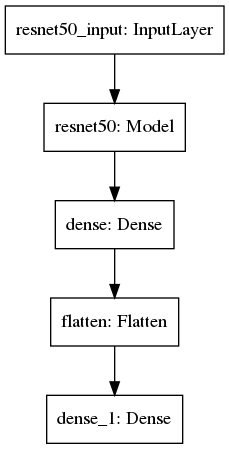

In [11]:
class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

def create_model():
    model = tf.keras.models.Sequential([
    tf.keras.applications.ResNet50(weights=None, pooling='max',classes=2048),
    tf.keras.layers.Dense(1024,activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='softmax'),
    ])
    return model
model = create_model()
plot_model(model, to_file='Sequential_Model.png')

Image('Sequential_Model.png')

In [12]:
def train_model():
    model = create_model()
    model.load_weights=('../aws-fpga-top-tagging-notebooks/dataset_Tom/weights-floatingpoint-224x224-fixval-best/class_weights.h5')
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics=[tf.keras.metrics.AUC(num_thresholds=200, curve='ROC')])
    logdir = os.path.join("logs","fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1, write_graph=True, write_images=True, )
    train_history = model.fit(x=train_img, y=train_label, epochs=10, batch_size=64,validation_data=(val_img, val_label), shuffle=True, callbacks=[tensorboard_callback])
    model.summary()
    return train_history, model
train_history, model = train_model()

Train on 20000 samples, validate on 2000 samples
Epoch 1/10
20000/20000 [==============================] - 117s 6ms/sample - loss: 0.4019 - auc: 0.8961 - val_loss: 1.5219 - val_auc: 0.5000
Epoch 2/10
20000/20000 [==============================] - 108s 5ms/sample - loss: 0.3074 - auc: 0.9377 - val_loss: 2.2377 - val_auc: 0.5018
Epoch 3/10
20000/20000 [==============================] - 108s 5ms/sample - loss: 0.3023 - auc: 0.9406 - val_loss: 0.3106 - val_auc: 0.9343
Epoch 4/10
20000/20000 [==============================] - 109s 5ms/sample - loss: 0.2866 - auc: 0.9469 - val_loss: 2.9020 - val_auc: 0.5000
Epoch 5/10
20000/20000 [==============================] - 109s 5ms/sample - loss: 0.2864 - auc: 0.9462 - val_loss: 2.2677 - val_auc: 0.5086
Epoch 6/10
20000/20000 [==============================] - 109s 5ms/sample - loss: 0.2827 - auc: 0.9468 - val_loss: 1.2985 - val_auc: 0.6981
Epoch 7/10
20000/20000 [==============================] - 109s 5ms/sample - loss: 0.2720 - auc: 0.9516 - val_lo

## Define function to visualize learning curve and prediction. <br><br>

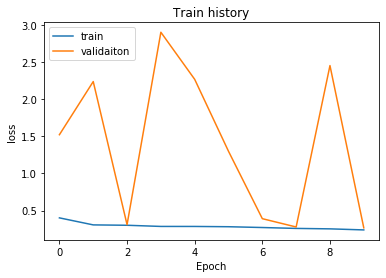

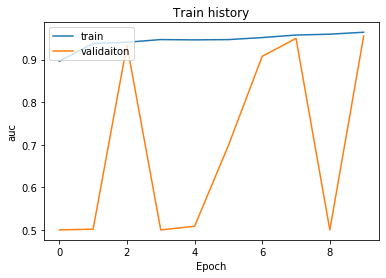

In [13]:
#Define a function to show training history
def show_train_history(train_history, train, validation,filename):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train history')
    plt.xlabel('Epoch')
    plt.ylabel(train)
    plt.legend(['train','validaiton'],loc='upper left')
    plt.savefig(filename)
    plt.show()


    
#Show the result of training 
show_train_history(train_history,'loss','val_loss','./loss_new.png')
show_train_history(train_history,'auc','val_auc',filename='./auc_new.png')


In [17]:
def plot_images_prediction(iamges, labels, prediction, idx, num = 10):
    fig = plt.gcf()
    fig.set_size_inches(12,14)
    if num>25: num=25
    for i in range(0,num):
        ax=plt.subplot(5,5,1+i)
        ax.imshow(iamges[idx], cmap='binary')
        title = "label=" + str(np.argmax(labels[idx]))
        if len(prediction)>0 :
            title += ",prediction=" + str(np.argmax(prediction[idx]))
        ax.set_title(title,fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
        idx+=1
    plt.savefig(filename)
    plt.show()

In [18]:
def plot_roc_curve(fpr,tpr,filename): 
    x = np.linspace(0,1)
    y = x
    plt.plot(fpr,tpr,label='model')
    plt.plot(x,y,label='random')
    plt.axis([0,1,0,1]) 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.savefig(filename)
    plt.show() 

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0.00815747 0.9918425 ]
 [0.00815747 0.9918425 ]
 [0.00815747 0.9918425 ]
 ...
 [0.00815747 0.9918425 ]
 [0.00815747 0.9918425 ]
 [0.00815747 0.9918425 ]]


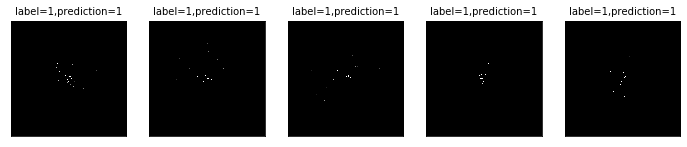

A best model was saved.


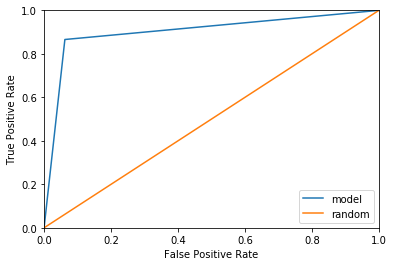

0.9019217295566009


In [20]:
from sklearn.metrics import roc_curve,roc_auc_score

#Scoring the accuracy of model by test dataset.
score = model.evaluate(test_img, test_label)
print()
print("Accuracy of model is", score[1])


#Prediction 
prediction = model.predict(test_img)
print(prediction)

plot_images_prediction(test_img,test_label, prediction,idx=1,num=5)


modelname = ""



if (score[1] > 0.85):
    path = os.path.join("model","best",)
    seq = (path, "my_weight_best_new_{0}.h5".format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))
    model.save_weights(modelname.join(seq))
    model.save('./model/my_model_best_new_{0}.h5'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))
    print('A best model was saved.')
    fpr , tpr , thresholds = roc_curve ( test_label[:,1]  , prediction[:,1] )   
    plot_roc_curve(fpr,tpr,'./roc_new_best_{0}.png'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))) 
    auc_score = roc_auc_score(test_label[:,1]  , prediction[:,1])
    print(auc_score)
elif (score[1] > 0.75) and (score[1] < 0.85):
    path = os.path.join("model","better",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),)
    seq = (path, "my_weight_better_new.h5")
    model.save_weights(modelname.join(seq))
    model.save('./model/my_model_better_new.h5')
    print('A better model was saved.')
    fpr , tpr , thresholds = roc_curve (test_label[:,1]  , prediction[:,1] )
    plot_roc_curve(fpr,tpr,'./roc_new_better.png') 
    auc_score = roc_auc_score(test_label[:,1]  , prediction[:,1])
    print(auc_score)
else:
    print('Not a good model, please try again.')



In [21]:
#Display confusion matrix
pd.crosstab(test_label_wo_onehot, pred, rownames=['label'], colnames=['predict'])

predict,0.0,1.0
label,,
0.0,966,64
1.0,130,840


In [22]:
#Display true value and predict value 
df = pd.DataFrame({'label':test_label_wo_onehot,'predict':pred})
df[:10]
#Find the result that true value is x but pred value is y (x != y)
#df[(df.label==1)&(df.predict==0)]

,label,predict
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
5,1.0,1.0
6,1.0,1.0
7,1.0,1.0
8,1.0,1.0
9,1.0,1.0


## Loading pre-trained model and test 

In [14]:
from sklearn.metrics import roc_curve,roc_auc_score
from tensorflow.keras.models import load_model
model_best = load_model('model/my_model_best_new_20200308-174931.h5')
model_best.summary()

model_best.load_weights('model/bestmy_weight_best_new_20200308-174931.h5')





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              27784064  
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 2050      
Total params: 29,884,290
Trainable params: 29,831,170
Non-trainable params: 53,120
_________________________________________________________________


640/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

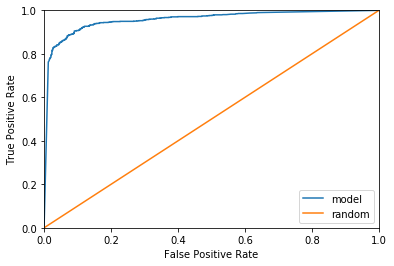

0.9574922430187168


In [20]:
best_prediction = model_best.predict(test_img)
#predict_class = model_best.predict_class(test_img)
best_score = model_best.evaluate(test_img, test_label,batch_size=64, steps=10)
print()
print("Accuracy of model is", best_score[1])

#plot_images_prediction(test_img, test_label, predict_class,idx=1,num=5)
best_fpr , best_tpr , best_thresholds = roc_curve (test_label[:,1], best_prediction[:,1])   
plot_roc_curve(best_fpr, best_tpr,'./roc_best.png') 
best_auc_score = roc_auc_score(test_label[:,1], best_prediction[:,1])
print(best_auc_score)

/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/home/david/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


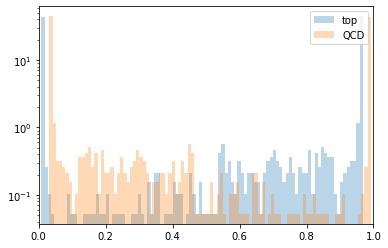

In [22]:
kwargs = dict(histtype='stepfilled', alpha=0.3, normed=True, bins=100)
plt.hist(best_prediction[:,0],**kwargs, label='top')
plt.hist(best_prediction[:,1],**kwargs,label='QCD')
plt.yscale('log')
plt.xlim(0.0,1.0)
plt.legend(loc='upper right')